Use XGBoost, no imputation required, best hyperparameters

Best hyperparameters: `colsample_bytree` $= 1.0$, `max_depth` $= 2$, `min_child_weight` $=2$, `learning_rate` $=0.01$, `subsample` $=1.0$.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/jovyan/data1030/data1030-oscars-prediction-project/data/pre_training_data.csv')
print("The shape of the dataset is: ")
print(df.shape)
print("The balance of the dataset is: ")
label = 'Oscar_Best_Picture_won'
y = df[label]
print(y.value_counts()/len(y))
X = df.drop(columns=['movie'])

The shape of the dataset is: 
(1235, 1019)
The balance of the dataset is: 
0    0.985425
1    0.014575
Name: Oscar_Best_Picture_won, dtype: float64


In [2]:
print("Of the features that have missing values, the fraction of missing values is:")
nulls = df.isnull().sum(axis=0)/df.shape[0]
print(nulls[nulls > 0])
print("")
print("The total fraction of missing features in the data set is:")
print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])
print("")

Of the features that have missing values, the fraction of missing values is:
metascore         0.023482
gross             0.034008
user_reviews      0.011336
critic_reviews    0.008097
popularity        0.109312
dtype: float64

The total fraction of missing features in the data set is:
0.12874493927125505



In [42]:
from sklearn.metrics import make_scorer, recall_score, precision_score, \
    confusion_matrix, fbeta_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost
import seaborn as sn
from matplotlib import pyplot as plt

num_cols = 'duration,rate,metascore,votes,gross,user_reviews,critic_reviews,popularity,awards_nominations,Oscar_nominated,Golden_Globes_nominated,BAFTA_won,BAFTA_nominated,Screen_Actors_Guild_won,Screen_Actors_Guild_nominated,Critics_Choice_won,Critics_Choice_nominated,Directors_Guild_won,Directors_Guild_nominated,Producers_Guild_won,Producers_Guild_nominated,Art_Directors_Guild_won,Art_Directors_Guild_nominated,Writers_Guild_won,Writers_Guild_nominated,Costume_Designers_Guild_won,Costume_Designers_Guild_nominated,Online_Film_Television_Association_won,Online_Film_Television_Association_nominated,Online_Film_Critics_Society_won,Online_Film_Critics_Society_nominated,People_Choice_won,People_Choice_nominated,London_Critics_Circle_Film_won,London_Critics_Circle_Film_nominated,American_Cinema_Editors_won,American_Cinema_Editors_nominated,Hollywood_Film_won,Hollywood_Film_nominated,Austin_Film_Critics_Association_won,Austin_Film_Critics_Association_nominated,Denver_Film_Critics_Society_won,Denver_Film_Critics_Society_nominated,Boston_Society_of_Film_Critics_won,Boston_Society_of_Film_Critics_nominated,New_York_Film_Critics_Circle_won,New_York_Film_Critics_Circle_nominated,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_nominated'
num_cols = [x for x in num_cols.split(',')]
mis_cols = df.columns[df.isna().any()].tolist()

np.random.seed(0)

In [47]:
mv = pd.read_csv('/home/jovyan/data1030/data1030-oscars-prediction-project/data/movies.csv')
oscars_2019 = list(mv.index[mv['year'] == 2018])
X_2019 = X.loc[oscars_2019]
X_train = X.drop(oscars_2019)
y_train = y.drop(oscars_2019)

In [43]:
cnts_transformer = Pipeline(steps = [('ss', StandardScaler())])
preprocessor = ColumnTransformer(transformers = [('num', cnts_transformer, num_cols)])
pipe = Pipeline(steps = [('preprocessor', preprocessor), ('clf', 
    xgboost.XGBClassifier(colsample_bytree=1.0, max_depth=2 , min_child_weight=2 , learning_rate=0.01 , subsample=1.0))])

In [61]:
pipe.fit(X_train, y_train);
y_pred_prob = pipe.predict_proba(X_2019)[:,1]
win_score = [np.around(100*x,1) for x in y_pred_prob]
movies_19 = list(mv['movie'].loc[oscars_2019])
pred_19 = pd.DataFrame(list(zip(movies_19,win_score)), columns = ['movie', 'win_prob'])

In [74]:
best_pic_noms = ['Black Panther', 'BlacKkKlansman', 'Bohemian Rhapsody', 'The Favourite', 'Green Book', 'Roma', 'A Star Is Born', 'Vice']
nom_preds = pred_19[pred_19['movie'].isin(best_pic_noms)]
nom_preds.sort_values(by='win_prob',ascending=False)

,movie,win_prob
20,Roma,45.9
14,The Favourite,25.1
4,Black Panther,21.1
1,A Star Is Born,18.9
3,Bohemian Rhapsody,18.5
21,Vice,18.5
32,Green Book,18.5
36,BlacKkKlansman,18.5


In [142]:
import pickle
xgb = pipe['clf']
df = pd.read_csv('/home/jovyan/data1030/data1030-oscars-prediction-project/data/pre_training_data.csv')
pickle.dump(xgb, open('/home/jovyan/data1030/data1030-oscars-prediction-project/results/model.pickle', 'wb')) 

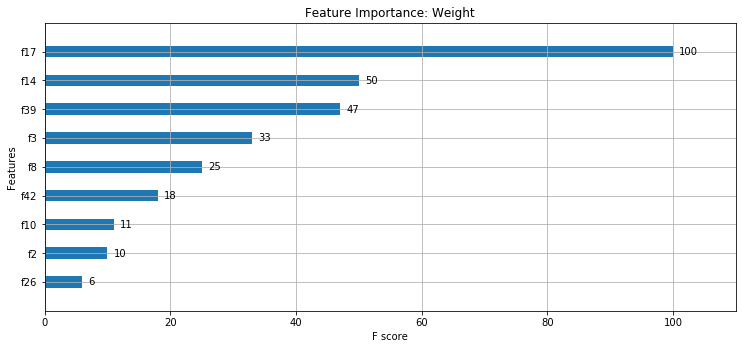

['Critics_Choice_won',
 'BAFTA_nominated',
 'Hollywood_Film_won',
 'votes',
 'awards_wins',
 'Austin_Film_Critics_Association_nominated',
 'Oscar_nominated',
 'metascore',
 'Writers_Guild_nominated']

In [130]:
fig= plt.figure(figsize=(12,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
xgboost.plot_importance(xgb,ax = axes, importance_type = 'weight', height=0.4, title='Feature Importance: Weight')
plt.show()
a = np.array(X_train.columns)
b = [17,14,39,3,8,42,10,2,26]
list(a[b])

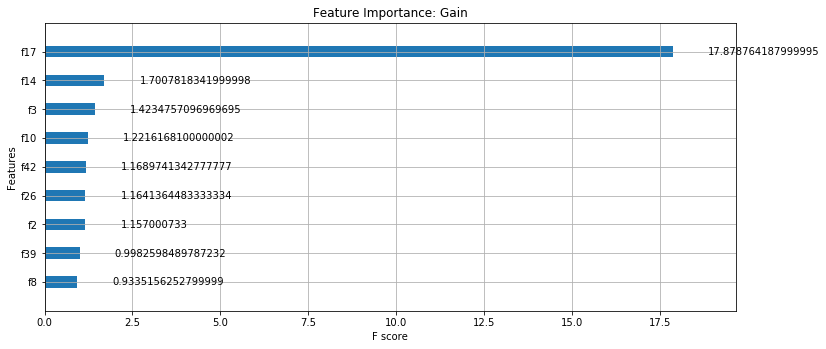

['Critics_Choice_won',
 'BAFTA_nominated',
 'votes',
 'Oscar_nominated',
 'Austin_Film_Critics_Association_nominated',
 'Writers_Guild_nominated',
 'metascore',
 'Hollywood_Film_won',
 'awards_wins']

In [132]:
fig= plt.figure(figsize=(12,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
xgboost.plot_importance(xgb,ax = axes, importance_type = 'gain', height=0.4, title='Feature Importance: Gain')
plt.show()
a = np.array(X_train.columns)
b = [17,14,3,10,42,26,2,39,8]
list(a[b])

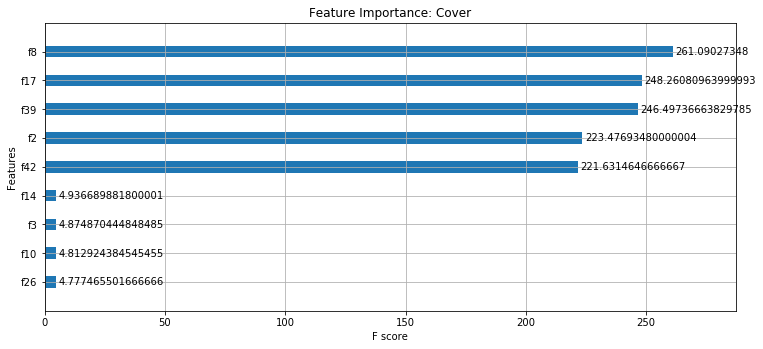

['awards_wins',
 'Critics_Choice_won',
 'Hollywood_Film_won',
 'metascore',
 'Austin_Film_Critics_Association_nominated',
 'BAFTA_nominated',
 'votes',
 'Oscar_nominated',
 'Writers_Guild_nominated']

In [139]:
fig= plt.figure(figsize=(12,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
xgboost.plot_importance(xgb,ax = axes, importance_type = 'cover', height=0.4, title='Feature Importance: Cover')
plt.show()
a = np.array(X_train.columns)
b = [8,17,39,2,42,14,3,10,26]
list(a[b])